<a href="https://colab.research.google.com/github/kenextra/IBM-MLCert/blob/main/Build_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Section

In [1]:
# install and reset runtime
%%bash
pip install --upgrade pandas --quiet
pip install --upgrade scikit-learn==0.24.0 --quiet
pip install --upgrade pyproj --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.


## Import needed libraries

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
# from collections import OrderedDict
from matplotlib.gridspec import GridSpec
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import plotly.express as px
sklearn.__version__

'0.24.0'

In [4]:
import os
import urllib.request
from zipfile import ZipFile
from pathlib import Path
from import_dataset import (load_data, basic_preprocessing,
                            add_dayof_week, add_timeof_day,
                            add_crow_direction, add_avespeed)

## Download Data

In [5]:
DATA_URL = "https://www.mathworks.com/supportfiles/practicaldsmatlab/taxi/Taxi%20Data.zip"
DATA_NAME = "TaxiData.zip"
urllib.request.urlretrieve(DATA_URL, DATA_NAME)

('TaxiData.zip', <http.client.HTTPMessage at 0x7f5548209d10>)

In [6]:
# Create a ZipFile Object and load data in it
with ZipFile(DATA_NAME, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [7]:
from pathlib import Path
DATA_DIR = Path.cwd() / 'Taxi Data'
DATA_DIR

PosixPath('/content/Taxi Data')

In [8]:
PROJECT_ROOT_DIR = Path.cwd()
COURSE_ID = "Deploy"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, COURSE_ID, "images")
IMAGES_PATH

'/content/Deploy/images'

In [9]:
os.makedirs(IMAGES_PATH, exist_ok=True)

In [10]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Import and Explore Data

In [11]:
col_names = ["Vendor", "PickupTime", "DropoffTime", "Passengers", "Distance", "PickupLon", "PickupLat",
             "RateCode", "HeldFlag", "DropoffLon", "DropoffLat", "PayType", "Fare", "ExtraCharge", "Tax",
             "Tip", "Tolls", "ImpSurcharge", "TotalCharge"];

In [12]:
use_cols = ['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RateCodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

parse_dates = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]

In [13]:
dtype = {'RateCodeID': str, 'payment_type': str, 'VendorID': str, 'RatecodeID': str,}  # , dtype=dtype

In [14]:
df = load_data(path_dir=DATA_DIR, parse_dates=parse_dates, 
                     usecols=use_cols, dtype=dtype,
                      file_substr='yellow', skiprows=1, preprocess=True)

Loading all yellow*.csv in /content/Taxi Data folder...

Converting categorical features to their corresponding values...

Removing invalid charges...

Removing invalid trip information...

Keep trips with pickup and drop off locations inside the region of interest

Adding new features: Duration...

Only keep trips with typical values..



In [15]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823895 entries, 0 to 2823894
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               2823895 non-null  object        
 1   tpep_pickup_datetime   2823895 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  2823895 non-null  datetime64[ns]
 3   passenger_count        2823895 non-null  int64         
 4   trip_distance          2823895 non-null  float64       
 5   pickup_longitude       2823895 non-null  float64       
 6   pickup_latitude        2823895 non-null  float64       
 7   RateCodeID             2823895 non-null  object        
 8   store_and_fwd_flag     2823895 non-null  object        
 9   dropoff_longitude      2823895 non-null  float64       
 10  dropoff_latitude       2823895 non-null  float64       
 11  payment_type           2823895 non-null  object        
 12  fare_amount            28238

In [16]:
df = add_timeof_day(df)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,time_of_day
0,VeriFone Inc.,2015-10-01 00:00:02,2015-10-01 00:17:37,2,5.68,-73.997597,40.756248,Standard rate,N,-73.941002,40.815140,Cash,18.5,0.5,0.5,0.00,0.0,0.3,19.80,17.583333,0.000556
1,VeriFone Inc.,2015-10-01 00:00:23,2015-10-01 00:13:12,5,7.13,-74.016586,40.709816,Standard rate,N,-73.959991,40.766918,Cash,20.5,0.5,0.5,0.00,0.0,0.3,21.80,12.816667,0.006389
2,VeriFone Inc.,2015-10-01 00:00:35,2015-10-01 00:12:17,2,1.72,-74.008247,40.714821,Standard rate,N,-73.984581,40.720299,Cash,9.5,0.5,0.5,0.00,0.0,0.3,10.80,11.700000,0.009722
3,VeriFone Inc.,2015-10-01 00:00:36,2015-10-01 00:09:45,1,1.06,-73.992363,40.737640,Standard rate,N,-73.993813,40.745838,Credit card,7.5,0.5,0.5,1.76,0.0,0.3,10.56,9.150000,0.010000
4,VeriFone Inc.,2015-10-14 10:23:37,2015-10-14 10:34:56,6,1.07,-74.001839,40.715561,Standard rate,N,-73.989189,40.714081,Credit card,8.5,0.0,0.5,1.00,0.0,0.3,10.30,11.316667,10.393611


In [17]:
df = add_dayof_week(df)

In [18]:
# drop mta_tax and improvement_surchage
df.drop(columns=['mta_tax', 'improvement_surcharge'], axis=1, inplace=True)

In [19]:
df['time_of_day'] = df.tpep_pickup_datetime.dt.hour
df['dayofmonth'] = df.tpep_pickup_datetime.dt.day
df['dayofyear'] = df.tpep_pickup_datetime.dt.dayofyear

## Engineer new features

In [20]:
import math
import pyproj
from geopy.distance import distance, geodesic
from pyproj import Geod
from scipy.spatial import distance

In [21]:
def add_dist(x):
    longg = x['pickup_longitude'] - x['dropoff_longitude']
    lat = x['pickup_latitude'] - x['dropoff_latitude']
    return math.sqrt(math.pow(longg, 2) + math.pow(lat, 2))


def add_long_euclid(x):
    longg = x['pickup_longitude'] - x['dropoff_longitude']
    return math.sqrt(math.pow(longg , 2))


def add_lat_euclid(x):
    lat = x['pickup_latitude'] - x['dropoff_latitude']
    return math.sqrt(math.pow(lat , 2))

In [22]:
df['dist'] = df.apply(add_dist, axis=1)

In [23]:
df['longitude'] = df.apply(add_long_euclid, axis=1)

In [24]:
df['latitude'] = df.apply(add_lat_euclid, axis=1)

In [25]:
# Keep only duration between 1 and 65 (inclusive)
df.query('duration > 1 & duration <= 65', inplace=True)

In [26]:
corr_matrix = df.corr()
corr_matrix['duration'].sort_values(ascending=False).to_frame()

,duration
duration,1.000000
fare_amount,0.888158
total_amount,0.860891
trip_distance,0.769640
dist,0.746093
longitude,0.664580
latitude,0.628793
tip_amount,0.493901
tolls_amount,0.434800
pickup_longitude,0.339413


In [27]:
for x in range(corr_matrix.shape[0]):
    corr_matrix.iloc[x,x] = 0.0
    
corr_matrix

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,tip_amount,tolls_amount,total_amount,duration,time_of_day,dayofmonth,dayofyear,dist,longitude,latitude
passenger_count,0.000000,0.014851,0.004079,-0.005532,0.000958,-0.002666,0.014525,0.002325,-0.006147,0.011870,0.011961,0.015363,0.009584,0.000086,-0.000766,0.011609,0.010313,0.009740
trip_distance,0.014851,0.000000,0.537816,-0.299000,0.437519,-0.183904,0.959887,-0.046980,0.550848,0.624418,0.949552,0.769640,-0.025022,-0.001235,0.016090,0.971902,0.897287,0.785555
pickup_longitude,0.004079,0.537816,0.000000,-0.100889,0.271521,0.044432,0.490951,-0.062136,0.260538,0.421789,0.490941,0.339413,0.022420,-0.001920,0.010544,0.535705,0.568769,0.315645
pickup_latitude,-0.005532,-0.299000,-0.100889,0.000000,0.059946,0.423634,-0.276161,-0.011583,-0.140450,-0.090297,-0.261395,-0.205959,0.018919,-0.000565,-0.004071,-0.297580,-0.279331,-0.252369
dropoff_longitude,0.000958,0.437519,0.271521,0.059946,0.000000,0.128153,0.400861,-0.011830,0.203279,0.301938,0.395922,0.256501,-0.057515,-0.001491,0.006594,0.454038,0.474455,0.276422
dropoff_latitude,-0.002666,-0.183904,0.044432,0.423634,0.128153,0.000000,-0.189522,-0.006796,-0.126961,-0.047900,-0.183718,-0.170694,0.020630,-0.001095,-0.001256,-0.163558,-0.146384,-0.124221
fare_amount,0.014525,0.959887,0.490951,-0.276161,0.400861,-0.189522,0.000000,-0.056312,0.565932,0.595955,0.981909,0.888158,-0.007772,-0.001301,0.028314,0.935507,0.856849,0.761598
extra,0.002325,-0.046980,-0.062136,-0.011583,-0.011830,-0.006796,-0.056312,0.000000,-0.006460,-0.067335,-0.022894,-0.045612,0.319875,0.001579,-0.001511,-0.048332,-0.064496,-0.018213
tip_amount,-0.006147,0.550848,0.260538,-0.140450,0.203279,-0.126961,0.565932,-0.006460,0.000000,0.427990,0.694852,0.493901,0.014060,-0.002856,0.016551,0.536724,0.508263,0.400876
tolls_amount,0.011870,0.624418,0.421789,-0.090297,0.301938,-0.047900,0.595955,-0.067335,0.427990,0.000000,0.667389,0.434800,0.002165,-0.002705,0.015614,0.606061,0.648121,0.313895


In [28]:
corr_matrix.abs().idxmax()

passenger_count              duration
trip_distance                    dist
pickup_longitude            longitude
pickup_latitude      dropoff_latitude
dropoff_longitude           longitude
dropoff_latitude      pickup_latitude
fare_amount              total_amount
extra                     time_of_day
tip_amount               total_amount
tolls_amount             total_amount
total_amount              fare_amount
duration                  fare_amount
time_of_day                     extra
dayofmonth                  dayofyear
dayofyear                  dayofmonth
dist                    trip_distance
longitude                        dist
latitude                         dist
dtype: object

In [29]:
df.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,tip_amount,tolls_amount,total_amount,duration,time_of_day,dayofmonth,dayofyear,dist,longitude,latitude
count,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06,2.811182e+06
mean,1.688307e+00,2.894729e+00,-7.397441e+01,4.075099e+01,-7.397358e+01,4.075167e+01,1.252901e+01,3.168561e-01,1.656223e+00,2.627318e-01,1.556483e+01,1.373390e+01,1.355762e+01,1.569921e+01,1.780464e+02,3.468955e-02,2.353565e-02,2.134464e-02
std,1.341573e+00,3.368760e+00,3.630811e-02,2.723918e-02,3.319511e-02,3.126977e-02,9.477949e+00,3.619762e-01,2.207920e+00,1.190760e+00,1.162708e+01,9.917867e+00,6.476197e+00,8.675092e+00,1.046562e+02,3.951670e-02,3.482014e-02,2.330176e-02
min,1.000000e+00,1.000000e-02,-7.419228e+01,4.057098e+01,-7.419228e+01,4.056189e+01,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,8.100000e-01,1.016667e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.020000e+00,-7.399207e+01,4.073722e+01,-7.399138e+01,4.073590e+01,6.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.750000e+00,6.716667e+00,9.000000e+00,8.000000e+00,8.700000e+01,1.289214e-02,6.370544e-03,7.045746e-03
50%,1.000000e+00,1.720000e+00,-7.398198e+01,4.075372e+01,-7.398005e+01,4.075419e+01,9.500000e+00,0.000000e+00,1.160000e+00,0.000000e+00,1.180000e+01,1.110000e+01,1.400000e+01,1.600000e+01,1.720000e+02,2.161374e-02,1.280212e-02,1.398849e-02
75%,2.000000e+00,3.200000e+00,-7.396791e+01,4.076805e+01,-7.396358e+01,4.076916e+01,1.450000e+01,5.000000e-01,2.300000e+00,0.000000e+00,1.776000e+01,1.783333e+01,1.900000e+01,2.300000e+01,2.700000e+02,3.866529e-02,2.423096e-02,2.680206e-02
max,9.000000e+00,4.080000e+01,-7.363151e+01,4.096010e+01,-7.359824e+01,4.096333e+01,1.000000e+02,7.000000e+00,1.100000e+02,2.000000e+01,1.200000e+02,6.500000e+01,2.300000e+01,3.100000e+01,3.650000e+02,4.054989e-01,4.014664e-01,3.080673e-01


In [30]:
df.shape

(2811182, 25)

## Choose target and feature variables/columns

In [31]:
# Extract features base on above correlation
label = ['duration']
features = ['longitude', 'latitude', 'dist', 'trip_distance',
            'time_of_day', 'day_of_week', 'passenger_count',
            'dayofmonth', 'dayofyear']
features

['longitude',
 'latitude',
 'dist',
 'trip_distance',
 'time_of_day',
 'day_of_week',
 'passenger_count',
 'dayofmonth',
 'dayofyear']

# General sklearn imports

In [32]:
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures, MinMaxScaler

# Train, Val, Split

In [33]:
len(features)

9

In [34]:
y = df[label]
X = df[features]

In [35]:
X.head()

,longitude,latitude,dist,trip_distance,time_of_day,day_of_week,passenger_count,dayofmonth,dayofyear
0,0.056595,0.058891,0.081677,5.68,0,Thursday,2,1,274
1,0.056595,0.057102,0.080397,7.13,0,Thursday,5,1,274
2,0.023666,0.005478,0.024292,1.72,0,Thursday,2,1,274
3,0.001450,0.008198,0.008325,1.06,0,Thursday,1,1,274
4,0.012650,0.001480,0.012736,1.07,10,Wednesday,6,14,287


In [36]:
X.tail()

,longitude,latitude,dist,trip_distance,time_of_day,day_of_week,passenger_count,dayofmonth,dayofyear
2823890,0.007011,0.003113,0.007671,2.34,12,Saturday,1,2,122
2823891,0.006577,0.001022,0.006656,1.65,23,Sunday,2,10,130
2823892,0.004700,0.018711,0.019292,1.78,10,Saturday,2,2,122
2823893,0.018097,0.000603,0.018107,1.30,15,Friday,2,8,128
2823894,0.019424,0.022137,0.029451,2.23,19,Thursday,1,21,141


In [37]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4,
                                                            random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,
                                                test_size=0.4, random_state=42)
print(f'Train data shape: {X_train.shape}\n')
print(f'Validation data shape: {X_val.shape}\n')
print(f'Test data shape: {X_test.shape}\n')

Train data shape: (1686709, 9)

Validation data shape: (674683, 9)

Test data shape: (449790, 9)



# General Transformers

## Transform label variable

In [38]:
from scipy import stats
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
import scipy as sp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5529988350>]],
      dtype=object)

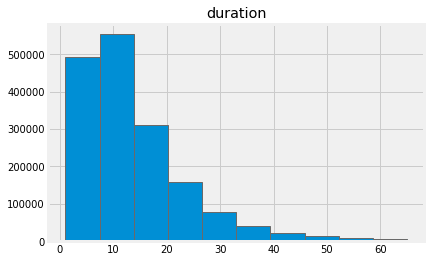

In [39]:
y_train.hist()
# save_fig('target')

In [40]:
normaltest(y_train.values.ravel())

NormaltestResult(statistic=540734.5616564872, pvalue=0.0)

NormaltestResult(statistic=13120.404727117795, pvalue=0.0)

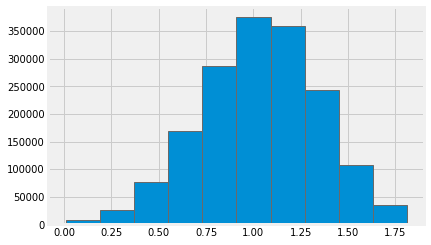

In [41]:
plt.hist(np.log10(y_train.values.ravel()))
normaltest(np.log10(y_train.values.ravel()))

## Build categorical and numerical pipeline



## Preprocess Features --> Scaling and encoding

In [42]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

In [43]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
numerical_cols, categorical_cols

(Index(['longitude', 'latitude', 'dist', 'trip_distance', 'time_of_day',
        'passenger_count', 'dayofmonth', 'dayofyear'],
       dtype='object'), Index(['day_of_week'], dtype='object'))

In [44]:
numerical_ix = [X.columns.get_loc(col) for col in numerical_cols]
categorical_ix = [X.columns.get_loc(col) for col in categorical_cols]
numerical_ix, categorical_ix

([0, 1, 2, 3, 4, 6, 7, 8], [5])

In [45]:
num_pipeline = Pipeline([("num", StandardScaler()),
                          # ("pca", PCA(n_components=11,random_state=42)),
                          # ("poly", PolynomialFeatures(degree=2)),
                         ])
num_pipeline

Pipeline(steps=[('num', StandardScaler())])

In [46]:
cat_pipeline = Pipeline([("cat", OrdinalEncoder()),
                         ])
cat_pipeline

Pipeline(steps=[('cat', OrdinalEncoder())])

In [47]:
transformer = ColumnTransformer([
                 ("num_pipe", num_pipeline, numerical_ix),
                 ("cat_pipe", cat_pipeline, categorical_ix),
                 ])
transformer

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('num', StandardScaler())]),
                                 [0, 1, 2, 3, 4, 6, 7, 8]),
                                ('cat_pipe',
                                 Pipeline(steps=[('cat', OrdinalEncoder())]),
                                 [5])])

# Build Regression Model

## Build and test simple model

In [134]:
errors = list()
scores = list()

### Linear Regression(First model)

In [135]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold

In [136]:
lr = LinearRegression(n_jobs=1, )
model = TransformedTargetRegressor(regressor=lr,
                                   func=np.log10,
                                   inverse_func=sp.special.exp10
                                   )

In [137]:
lr_estimator = Pipeline([('preparation', transformer), 
                     ('model', model)
                     ])

In [138]:
lr_estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preparation', 'model', 'preparation__n_jobs', 'preparation__remainder', 'preparation__sparse_threshold', 'preparation__transformer_weights', 'preparation__transformers', 'preparation__verbose', 'preparation__num_pipe', 'preparation__cat_pipe', 'preparation__num_pipe__memory', 'preparation__num_pipe__steps', 'preparation__num_pipe__verbose', 'preparation__num_pipe__num', 'preparation__num_pipe__num__copy', 'preparation__num_pipe__num__with_mean', 'preparation__num_pipe__num__with_std', 'preparation__cat_pipe__memory', 'preparation__cat_pipe__steps', 'preparation__cat_pipe__verbose', 'preparation__cat_pipe__cat', 'preparation__cat_pipe__cat__categories', 'preparation__cat_pipe__cat__dtype', 'preparation__cat_pipe__cat__handle_unknown', 'preparation__cat_pipe__cat__unknown_value', 'model__check_inverse', 'model__func', 'model__inverse_func', 'model__regressor__copy_X', 'model__regressor__fit_intercept', 'model__regressor__n_jobs', 'model__regresso

In [139]:
lr_estimator.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 6, 7, 8]),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat',
                                                                   OrdinalEncoder())]),
                                                  [5])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LinearRegression(n_jobs=1)))])

In [140]:
# predict
y_train_pred = lr_estimator.predict(X_train)
y_val_pred = lr_estimator.predict(X_val)
y_test_pred = lr_estimator.predict(X_test)

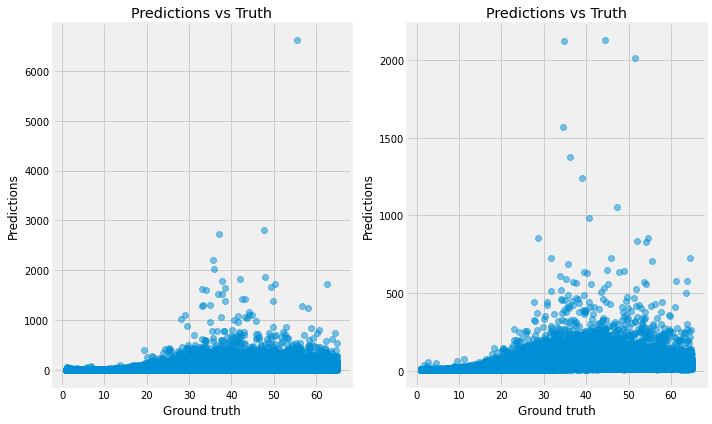

In [141]:
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 6)

# axList[-1].axis('off')

data = [[y_train, y_train_pred], [y_test, y_test_pred]]
for ax, y_value in zip(axList, data):
    ax.scatter(y_value[0], y_value[1], alpha=.5)

    ax.set(xlabel='Ground truth', 
        ylabel='Predictions',
        title='Predictions vs Truth')
plt.tight_layout()
# save_fig('linearRegression')

In [142]:
errors.append(pd.Series({'train': r2_score(y_train, y_train_pred),
           'val': r2_score(y_val, y_val_pred,),
           'test' : r2_score(y_test, y_test_pred)},
          name='LR_score'))

errors.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred, squared=False),
           'val': mean_squared_error(y_val_pred, y_val, squared=False),
           'test' : mean_squared_error(y_test,  y_test_pred, squared=False)},
          name='LR_rmse'))

In [143]:
pd.concat(errors, axis=1)

,LR_score,LR_rmse
train,-1.359818,15.232537
val,-1.179206,14.650705
test,-1.126861,14.460062


In [144]:
lr_estimator.predict([[0.0, 0.0, 0.0, 0.0, 12, 'Thursday', 1, 12, 224]])

array([[6.97905219]])

### Random Forest Regressor

In [145]:
from sklearn.ensemble import RandomForestRegressor

#### Grid search

In [146]:
rfr = RandomForestRegressor(random_state=42,n_jobs=-1)
model = TransformedTargetRegressor(regressor=rfr,
                                   func=np.log10,
                                   inverse_func=sp.special.exp10
                                   )

In [147]:
estimator = Pipeline([('preparation', transformer), 
                     ('model', model)
                     ])

In [148]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preparation', 'model', 'preparation__n_jobs', 'preparation__remainder', 'preparation__sparse_threshold', 'preparation__transformer_weights', 'preparation__transformers', 'preparation__verbose', 'preparation__num_pipe', 'preparation__cat_pipe', 'preparation__num_pipe__memory', 'preparation__num_pipe__steps', 'preparation__num_pipe__verbose', 'preparation__num_pipe__num', 'preparation__num_pipe__num__copy', 'preparation__num_pipe__num__with_mean', 'preparation__num_pipe__num__with_std', 'preparation__cat_pipe__memory', 'preparation__cat_pipe__steps', 'preparation__cat_pipe__verbose', 'preparation__cat_pipe__cat', 'preparation__cat_pipe__cat__categories', 'preparation__cat_pipe__cat__dtype', 'preparation__cat_pipe__cat__handle_unknown', 'preparation__cat_pipe__cat__unknown_value', 'model__check_inverse', 'model__func', 'model__inverse_func', 'model__regressor__bootstrap', 'model__regressor__ccp_alpha', 'model__regressor__criterion', 'model__regres

In [149]:
# Set parameters
MAX_DEPTH_OPTIONS = [15, 20]
N_ESTIMATORS = [10, 15]
params = {
    'model__regressor__max_depth': MAX_DEPTH_OPTIONS,
    'model__regressor__n_estimators': N_ESTIMATORS,
}

kf = KFold(shuffle=True, random_state=42, n_splits=5)

In [150]:
grid = GridSearchCV(estimator, params, verbose=10, n_jobs=1, cv=kf,
                    scoring='neg_mean_squared_error', return_train_score=True)

In [151]:
grid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START model__regressor__max_depth=15, model__regressor__n_estimators=10
[CV 1/5; 1/4] END model__regressor__max_depth=15, model__regressor__n_estimators=10; total time= 1.4min
[CV 2/5; 1/4] START model__regressor__max_depth=15, model__regressor__n_estimators=10
[CV 2/5; 1/4] END model__regressor__max_depth=15, model__regressor__n_estimators=10; total time= 1.5min
[CV 3/5; 1/4] START model__regressor__max_depth=15, model__regressor__n_estimators=10
[CV 3/5; 1/4] END model__regressor__max_depth=15, model__regressor__n_estimators=10; total time= 1.5min
[CV 4/5; 1/4] START model__regressor__max_depth=15, model__regressor__n_estimators=10
[CV 4/5; 1/4] END model__regressor__max_depth=15, model__regressor__n_estimators=10; total time= 1.5min
[CV 5/5; 1/4] START model__regressor__max_depth=15, model__regressor__n_estimators=10
[CV 5/5; 1/4] END model__regressor__max_depth=15, model__regressor__n_estimators=10; total tim

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('num',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 6,
                                                                          7,
                                                                          8]),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('cat',
                                                                                          OrdinalEncoder())]),
                                                                         [5])])),
                                       ('model',
                                        TransformedTargetRegressor(func=<ufunc 'log10'>,
                                                                   inverse_func=<ufunc 'exp10'>,
                                                                   regressor=RandomForestRegressor(n_jobs=-1,
                                                                                                   random_state=42)))]),
             n_jobs=1,
             param_grid={'model__regressor__max_depth': [15, 20],
                         'model__regressor__n_estimators': [10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=10)

In [152]:
grid.best_score_, grid.best_params_

(-23.449333726023394,
 {'model__regressor__max_depth': 20, 'model__regressor__n_estimators': 15})

In [153]:
# predict
y_train_pred = grid.predict(X_train)
y_val_pred = grid.predict(X_val)
y_test_pred = grid.predict(X_test)

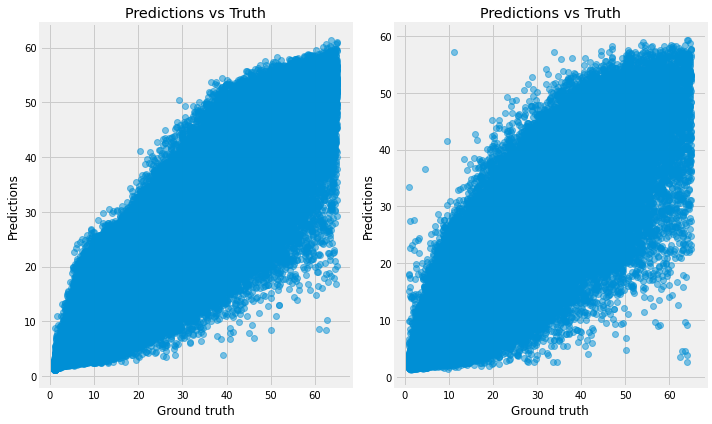

In [154]:
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 6)

# axList[-1].axis('off')

data = [[y_train, y_train_pred], [y_test, y_test_pred]]
for ax, y_value in zip(axList, data):
    ax.scatter(y_value[0], y_value[1], alpha=.5)

    ax.set(xlabel='Ground truth', 
        ylabel='Predictions',
        title='Predictions vs Truth')
plt.tight_layout()
# save_fig('randomForest')

In [155]:
errors.append(pd.Series({'train': r2_score(y_train_pred, y_train),
           'val': r2_score(y_val_pred, y_val),
           'test' : r2_score(y_test_pred, y_test)},
          name='RFR_Grid_score'))

errors.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred, squared=False),
           'val': mean_squared_error(y_val_pred, y_val, squared=False),
           'test' : mean_squared_error(y_test,  y_test_pred, squared=False)},
          name='RFR_Grid_rmse'))

pd.concat(errors, axis=1)

,LR_score,LR_rmse,RFR_Grid_score,RFR_Grid_rmse
train,-1.359818,15.232537,0.807447,3.801263
val,-1.179206,14.650705,0.680037,4.838000
test,-1.126861,14.460062,0.678085,4.844768


#### Retrain best Model

In [156]:
parameters = grid.best_params_
n_estimators = parameters['model__regressor__n_estimators']
max_depth = parameters['model__regressor__max_depth']
max_depth, n_estimators

(20, 15)

In [157]:
rfr = RandomForestRegressor(n_estimators=n_estimators,  max_depth=max_depth, random_state=42,)
model = TransformedTargetRegressor(regressor=rfr,
                                   func=np.log10,
                                   inverse_func=sp.special.exp10
                                   )

In [158]:
rfr_estimator = Pipeline([('preparation', transformer), 
                     ('model', model)
                     ])

In [159]:
rfr_estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preparation', 'model', 'preparation__n_jobs', 'preparation__remainder', 'preparation__sparse_threshold', 'preparation__transformer_weights', 'preparation__transformers', 'preparation__verbose', 'preparation__num_pipe', 'preparation__cat_pipe', 'preparation__num_pipe__memory', 'preparation__num_pipe__steps', 'preparation__num_pipe__verbose', 'preparation__num_pipe__num', 'preparation__num_pipe__num__copy', 'preparation__num_pipe__num__with_mean', 'preparation__num_pipe__num__with_std', 'preparation__cat_pipe__memory', 'preparation__cat_pipe__steps', 'preparation__cat_pipe__verbose', 'preparation__cat_pipe__cat', 'preparation__cat_pipe__cat__categories', 'preparation__cat_pipe__cat__dtype', 'preparation__cat_pipe__cat__handle_unknown', 'preparation__cat_pipe__cat__unknown_value', 'model__check_inverse', 'model__func', 'model__inverse_func', 'model__regressor__bootstrap', 'model__regressor__ccp_alpha', 'model__regressor__criterion', 'model__regres

In [160]:
rfr_estimator.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 6, 7, 8]),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat',
                                                                   OrdinalEncoder())]),
                                                  [5])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RandomForestRegressor(max_depth=20,
                                                                            n_estimators=15,
                                                                            random_state=42)))])

#### predict

In [161]:
# predict
y_train_pred = rfr_estimator.predict(X_train)
y_val_pred = rfr_estimator.predict(X_val)
y_test_pred = rfr_estimator.predict(X_test)

In [162]:
rfr_estimator.predict([[0.0, 0.0, 0.0, 0.0, 12, 'Thursday', 1, 12, 224]])

array([2.31099686])

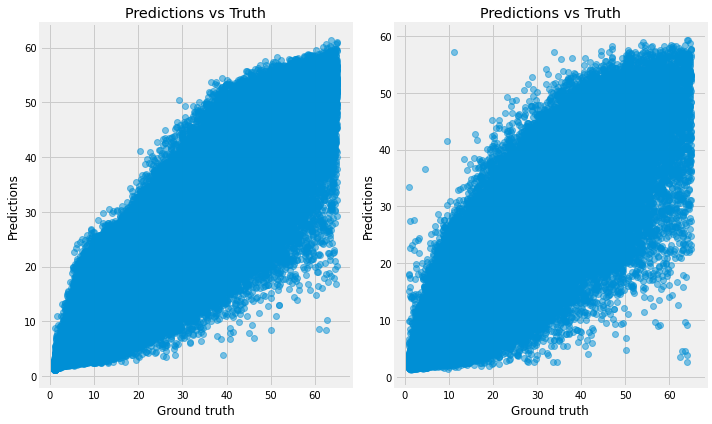

In [163]:
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 6)

# axList[-1].axis('off')

data = [[y_train, y_train_pred], [y_test, y_test_pred]]
for ax, y_value in zip(axList, data):
    ax.scatter(y_value[0], y_value[1], alpha=.5)

    ax.set(xlabel='Ground truth', 
        ylabel='Predictions',
        title='Predictions vs Truth')
plt.tight_layout()
# save_fig('randomForest')

In [164]:
errors.append(pd.Series({'train': r2_score(y_train_pred, y_train),
           'val': r2_score(y_val_pred, y_val),
           'test' : r2_score(y_test_pred, y_test)},
          name='RFC_score'))

errors.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred, squared=False),
           'val': mean_squared_error(y_val_pred, y_val, squared=False),
           'test' : mean_squared_error(y_test,  y_test_pred, squared=False)},
          name='RFC_rmse'))

In [165]:
pd.concat(errors, axis=1)

,LR_score,LR_rmse,RFR_Grid_score,RFR_Grid_rmse,RFC_score,RFC_rmse
train,-1.359818,15.232537,0.807447,3.801263,0.807447,3.801263
val,-1.179206,14.650705,0.680037,4.838000,0.680037,4.838000
test,-1.126861,14.460062,0.678085,4.844768,0.678085,4.844768


#### Save model

In [166]:
import joblib
joblib.__version__

'1.0.1'

In [167]:
joblib.dump(rfc_estimator, 'Deploy/model.joblib')

['Deploy/model.joblib']

### Extra Tree Regressor

In [168]:
from sklearn.ensemble import ExtraTreesRegressor

In [169]:
etr = ExtraTreesRegressor(random_state=42, n_estimators=n_estimators, max_depth=max_depth, verbose=10,)
model = TransformedTargetRegressor(regressor=etr,
                                   func=np.log10,
                                   inverse_func=sp.special.exp10
                                   )

In [170]:
etr_estimator = Pipeline([('preparation', transformer), 
                     ('model', model)
                     ])

In [171]:
etr_estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preparation', 'model', 'preparation__n_jobs', 'preparation__remainder', 'preparation__sparse_threshold', 'preparation__transformer_weights', 'preparation__transformers', 'preparation__verbose', 'preparation__num_pipe', 'preparation__cat_pipe', 'preparation__num_pipe__memory', 'preparation__num_pipe__steps', 'preparation__num_pipe__verbose', 'preparation__num_pipe__num', 'preparation__num_pipe__num__copy', 'preparation__num_pipe__num__with_mean', 'preparation__num_pipe__num__with_std', 'preparation__cat_pipe__memory', 'preparation__cat_pipe__steps', 'preparation__cat_pipe__verbose', 'preparation__cat_pipe__cat', 'preparation__cat_pipe__cat__categories', 'preparation__cat_pipe__cat__dtype', 'preparation__cat_pipe__cat__handle_unknown', 'preparation__cat_pipe__cat__unknown_value', 'model__check_inverse', 'model__func', 'model__inverse_func', 'model__regressor__bootstrap', 'model__regressor__ccp_alpha', 'model__regressor__criterion', 'model__regres

In [172]:
etr_estimator.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 15


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


building tree 2 of 15


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


building tree 3 of 15


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s remaining:    0.0s


building tree 4 of 15


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.5s remaining:    0.0s


building tree 5 of 15


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.8s remaining:    0.0s


building tree 6 of 15


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.2s remaining:    0.0s


building tree 7 of 15


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   36.7s remaining:    0.0s


building tree 8 of 15


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.8s remaining:    0.0s


building tree 9 of 15


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   47.3s remaining:    0.0s


building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min finished


Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 6, 7, 8]),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat',
                                                                   OrdinalEncoder())]),
                                                  [5])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=ExtraTreesRegressor(max_depth=20,
                                                                          n_estimators=15,
                                                                          random_state=42,
                                                                          verbose=10)))])

In [173]:
# predict
y_train_pred = etr_estimator.predict(X_train)
y_val_pred = etr_estimator.predict(X_val)
y_test_pred = etr_estimator.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elap

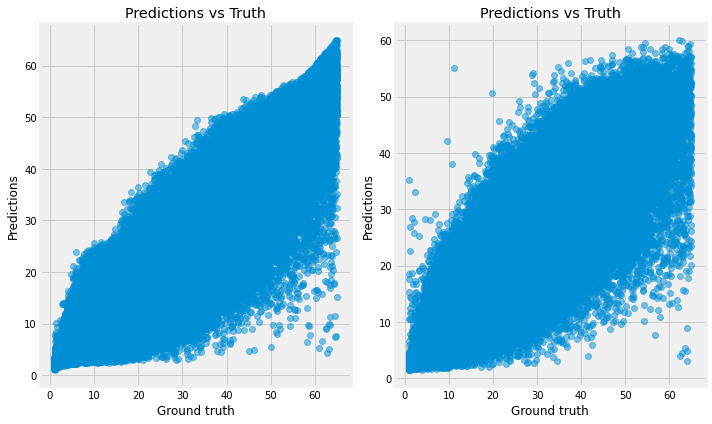

In [174]:
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 6)

# axList[-1].axis('off')

data = [[y_train, y_train_pred], [y_test, y_test_pred]]
for ax, y_value in zip(axList, data):
    ax.scatter(y_value[0], y_value[1], alpha=.5)

    ax.set(xlabel='Ground truth', 
        ylabel='Predictions',
        title='Predictions vs Truth')
plt.tight_layout()

In [175]:
errors.append(pd.Series({'train': r2_score(y_train_pred, y_train),
           'val': r2_score(y_val_pred, y_val),
           'test' : r2_score(y_test_pred, y_test)},
          name='ETC_score'))

errors.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred, squared=False),
           'val': mean_squared_error(y_val_pred, y_val, squared=False),
           'test' : mean_squared_error(y_test,  y_test_pred, squared=False)},
          name='ETC_rmse'))

In [176]:
pd.concat(errors, axis=1)

,LR_score,LR_rmse,RFR_Grid_score,RFR_Grid_rmse,RFC_score,RFC_rmse,ETC_score,ETC_rmse
train,-1.359818,15.232537,0.807447,3.801263,0.807447,3.801263,0.789330,3.944965
val,-1.179206,14.650705,0.680037,4.838000,0.680037,4.838000,0.668129,4.855416
test,-1.126861,14.460062,0.678085,4.844768,0.678085,4.844768,0.666071,4.862690
